# Few Shot Learning- Data Loader

**Notebook內容：**
1. Data Loader for Transfer Learning
3. Data Loader for Meta Learning

## 資料探索與資料讀取

In [1]:
!git clone https://github.com/DeepStudio-TW/small-data-ssl-lecture.git
!cd small-data-ssl-lecture

fatal: destination path 'small-data-ssl-lecture' already exists and is not an empty directory.


In [5]:
# 升級 gdown 套件
!pip install -q --upgrade gdown
# Download dataset
!gdown -q  https://drive.google.com/uc?id=1XagZtTeUhFWiXvlZabja0XJhBMwQFl6j&export=download
# Unzip the files
!tar zxf  mnistm_half.tar.gz

## 1. Loader for Transfer Learning

### 1.1 範例內容
* 資料來源: 
    * Source: [MNIST-M](https://paperswithcode.com/dataset/mnist-m) 0~9 數字圖片混入BSDS500照片資料庫背景
    * Target: [MNIST](http://yann.lecun.com/exdb/mnist/) 0~9 數字圖片資料

* Label: 
    * Source data label 0~9
    * target data label 0~9
    * test data不使用 label訓練，純粹驗證用

In [1]:
# 讀取基本套件
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
# Backend: pytorch
import torch

In [2]:
# 設一個 show data和label的function
def show_data(imgs, titles,cmap=None):
    # imshow, 縮放模式為nearest。
    plt.figure(figsize=(18, 18))
    for id,(img,title) in enumerate(zip(imgs,titles)):
        plt.subplot(1, len(titles), id+1)
        fig = plt.imshow(img,interpolation='nearest',cmap=cmap)
        plt.axis("off")
        plt.title(title)

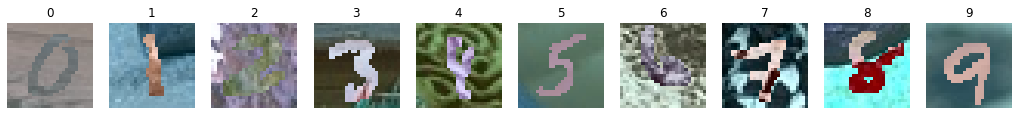

In [3]:
# 試看source data: 
titles = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
example_files=[glob(f"mnistm_half/mnist_m_test/{i}/*.png")[0] for i in titles]
show_data([*map(plt.imread,example_files)],titles)

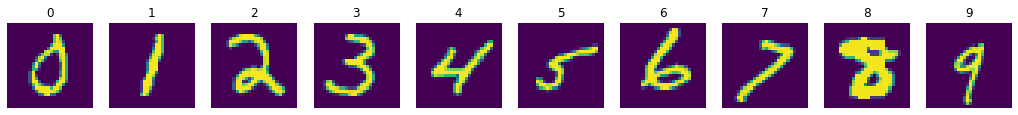

In [4]:
# 看target data
example_files=[glob(f"mnistm_half/mnist_train/{i}/*.png")[0] for i in titles]
show_data([*map(plt.imread,example_files)],titles)

### 1.2 Data Loader設計
這邊我們三個loader
* source: 來源資料集，有MNIST-M圖片，也有對應的label
* target: 目標資料集，只有少量MNIST 圖片，也有對應的label
* test: 測試資料集，有MNIST圖片，也有對應的label

Data Loader的要件:
* dataset: torchvision的VisionDataset，我們這邊使用ImageFolder作，只要把圖片依照分類放進資料夾就能依照資料夾名稱指定分類：
```
data_root
|--class 1
|   |--image 1
|   |--image 2
|   ...
|--class 2
|   |--image 3
...
```
* transform: augmentation function，這邊使用torchvision.transforms來做，也推薦[cv2 wrapaffine](https://theailearner.com/tag/cv2-warpaffine/)或者[aubmentation](https://github.com/albumentations-team/albumentations)，因為這是Deep Learning CV的基本所以這邊不多贅述。

#### 1.2.1 Dataset Object

In [5]:
import torchvision.transforms as tvt
import torchvision.datasets as tvds

In [6]:
# 生成一個 augmnetation function
train_transform = tvt.Compose([
    tvt.RandomHorizontalFlip(),
    # 旋轉15度內 (Augmentation)，旋轉後空的地方補0
    tvt.RandomRotation(15, fill=(0,0,0)),
    # 最後轉成Tensor供model使用。
    tvt.ToTensor(),
])


In [7]:
# torchvision 會先讀取圖檔再做augmentation
# 而讀取圖檔的初始形式是PIL格式
import PIL
before=PIL.Image.open(example_files[9]).convert('RGB')

In [8]:
# 根據設定，會依照機率做水平翻轉、旋轉15度
after=train_transform(before)

In [9]:
# 不過依照pytorch default, 會轉成[channels, width,height]的大小
# 這個tensor到後面是可以繼續跑的，但畫出來要做一些axis轉置變成[width,height, channels]
after.shape

torch.Size([3, 28, 28])

In [10]:
# 轉成numpy array比較好做axis轉置
# 轉置numpy array可以直接指定新axis 順序 
after.numpy().transpose(1,2,0).shape

(28, 28, 3)

In [11]:
# 用torch tensor直接轉置必須轉兩次 
after.transpose(0,1).transpose(1,2).shape

torch.Size([28, 28, 3])

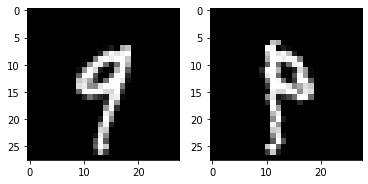

In [12]:
plt.figure()
plt.subplot(1,2,1);plt.imshow(np.array(before))
plt.subplot(1,2,2);plt.imshow(after.numpy().transpose(1,2,0))

In [13]:
# Source套用source的transform
source_dataset = tvds.ImageFolder('mnistm_half/mnist_m_train', transform=train_transform)

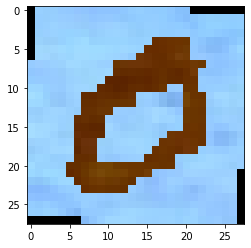

In [14]:
for img,label in source_dataset:
    plt.figure()
    plt.imshow(img.numpy().transpose(1,2,0))
    break

In [15]:
## Target dataset object也用同樣步驟產生，但是我們不希望他做augmentation，所以不會有旋轉、翻轉等等步驟

test_transform = tvt.Compose([
    tvt.ToTensor(),
])
# Target套用target的transform
target_dataset = tvds.ImageFolder('mnistm_half/mnist_train', transform=train_transform)
# Testing與Target那邊一樣資料，但會把label拿起來算準確度
test_dataset = tvds.ImageFolder('mnistm_half/mnist_test', transform=test_transform)

#### 1.2.2 Dataloader Object

Dataset object指定單個資料前處理的形式，build 成 data loader object則可以指定batch輸出給model使用的形式

形成source dataset的dataloader

In [16]:
from torch.utils.data import DataLoader
# source跟target都使用小batch size
BS_TRAIN=32
source_dataloader=DataLoader(source_dataset, # 指定source dataset物件
                    batch_size=BS_TRAIN,     # batch size
                    shuffle=True,            # source set要shuffle
                    num_workers=2,           # 開啟兩個thread
                    pin_memory=True)         # 其他增加讀取速度的功能都可以開

Loaded data, label shapes torch.Size([32, 3, 28, 28]) torch.Size([32])


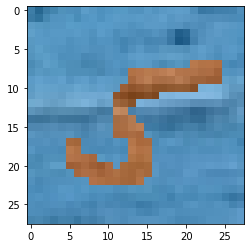

In [17]:
for img_batch,label_batch in source_dataloader:
    print("Loaded data, label shapes",img_batch.shape,label_batch.shape)
    plt.figure()
    plt.imshow(img_batch[0].numpy().transpose(1,2,0))
    break

In [18]:
# loading結果會在CPU上 等會再放到GPU
img_batch.device

device(type='cpu')

##### 1.2.2.1 Sampler for target training dataset

形成target的data loader

我們預設target dataset中的tarining dataset僅有N-way-K-shot而已

所以我們切分training set跟testing set 可以先生成抽取N-way-K-shot的function

這邊我們用 torch 的Sampler class來做

In [19]:
source_dataset.class_to_idx

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

In [159]:
## get subset: 將dataset每個內容拿出來，若class與指定class (c)相同則存起來
shots=5 # 這邊指定一個shot數，以後包成Class會從self.shots中讀取
ds_object=target_dataset # 這邊指定一個sdataset，以後包成Class會從self.data_source讀取
classes='0123456789'

new_target_list=np.random.permutation([*enumerate(ds_object.targets)])

indices=[]
for c in classes:
    count=shots
    for ii,yy in new_target_list:
        # 若已抽到 shot個則停止
        if count==0:
            break
        # 還未抽到則檢查該label是否為指定class
        if yy==ds_object.class_to_idx[c]:
            # 若是，則
            indices.append(ii)
            count-=1

In [160]:
print("選出來的sample:",indices)
print("這些sample的label:", np.array(ds_object.targets)[indices])

選出來的sample: [2278, 630, 1808, 1790, 2378, 4852, 4381, 3576, 4570, 3752, 6479, 7699, 7992, 7099, 8738, 9788, 10905, 11754, 9418, 11938, 12900, 12883, 12736, 13221, 14460, 17897, 16716, 16969, 15372, 16676, 19105, 19675, 18829, 20417, 19518, 23210, 21967, 24036, 22925, 21175, 26294, 26748, 24251, 26932, 26903, 28580, 28761, 28581, 29120, 27852]
這些sample的label: [0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5 6 6 6 6 6 7 7
 7 7 7 8 8 8 8 8 9 9 9 9 9]


In [22]:
repeats=3 # 在dataset總數少的時候，為了可以組batch，直接把原本data重複數次，增加可以開
indices=np.repeat(indices,repeats)
print("選出來的sample:",indices)
print("這些sample的label:", np.array(ds_object.targets)[indices])

選出來的sample: [ 2265  2265  2265  1871  1871  1871   843   843   843  1343  1343  1343
  2738  2738  2738  3966  3966  3966  3275  3275  3275  4889  4889  4889
  5247  5247  5247  3976  3976  3976  6703  6703  6703  9264  9264  9264
  9173  9173  9173  6557  6557  6557  8949  8949  8949  9879  9879  9879
  9760  9760  9760 11998 11998 11998 11141 11141 11141  9612  9612  9612
 14550 14550 14550 14656 14656 14656 14940 14940 14940 12880 12880 12880
 13601 13601 13601 15363 15363 15363 16346 16346 16346 16301 16301 16301
 16691 16691 16691 16081 16081 16081 20027 20027 20027 20747 20747 20747
 18818 18818 18818 19398 19398 19398 19393 19393 19393 21819 21819 21819
 22789 22789 22789 21453 21453 21453 23609 23609 23609 21924 21924 21924
 24350 24350 24350 24626 24626 24626 25126 25126 25126 26398 26398 26398
 24404 24404 24404 27584 27584 27584 28245 28245 28245 27575 27575 27575
 28166 28166 28166 28111 28111 28111]
這些sample的label: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [23]:
# 最後每次使用時會把以上index做random shuffle:
class_samples=indices
np.random.shuffle(class_samples)
print("選出來的sample:",class_samples)
print("這些sample的label:", np.array(ds_object.targets)[class_samples])

選出來的sample: [18818  2738 22789 14656  4889 28166 26398  2265  9879 26398  1871  1343
  6703 13601  6557 16301 28166 24404  5247 24626  3976 21924 19398 24626
  9264  6703 27575  9760 24350 14940 24350  9612 27584 28111 25126  1871
  3966 20027  2265  9173  6703  9264 27575   843 19393  3976 23609  6557
  4889 21924 16346  2738  9879 20747 11998 13601 16301  3976 16691 23609
 20027 19393 21819  9173  2265 14940 12880 21819  9879  3275 22789 12880
 14550 11998 26398 11998  8949  3275 27584 25126 16346 21453   843  8949
 28245 18818 15363 14550   843  6557 28245 16691 21453 11141 16081 25126
 14656 19398 24626 28111  9612 11141 21819  9760 15363  8949 14940 24404
 16081  1343  5247 28111  4889  3275 27584 18818  9173 19398 24404 21453
  9612 11141  3966  1871 15363 24350 16301 20027 14656  9264 21924  9760
 16691 28245 23609  1343 16346 20747  5247 28166 27575 19393 14550 22789
 16081  3966 20747  2738 12880 13601]
這些sample的label: [6 0 7 4 1 9 8 0 3 8 0 0 2 4 2 5 9 8 1 8 1 7 6 8 2 2 9 3 8

In [87]:
from torch.utils import data as tud

# 組成class吧
class FewShotSampler(tud.Sampler):
    def __init__(self,ds_object,classes,shots,repeats=16,shuffle=True):
        # 儲存參數進object
        self.ds_object=ds_object
        self.classes=classes
        self.shots=shots
        self.repeats=repeats # 在dataset總數少的時候，為了可以組batch，會把多個epoch的資料疊在一起
        self.class_samples=self.get_samples()
        self.shuffle=shuffle
        
    def get_samples(self):
        # 將dataset每個內容拿出來，若class與指定clas相同則存起來
        new_target_list=np.random.permutation([*enumerate(self.ds_object.targets)])

        indices=[]
        for c in self.classes:
            count=self.shots
            for ii,yy in new_target_list:
                # 若已抽到 shot個則停止
                if count==0:
                    break
                # 還未抽到則檢查該label是否為指定class
                if yy==self.ds_object.class_to_idx[c]:
                    # 若是，則加入列表
                    indices.append(ii)
                    count-=1
        return np.repeat(indices,self.repeats)
    
    def __len__(self):
        return len(self.class_samples)
    def __iter__(self):
        if self.shuffle:
            return iter(np.random.permutation(self.class_samples))
        return iter(self.class_samples)

In [25]:
# 再使用時指定way數跟shot數，這邊使用0,1,2,...,WAYS-1 這些class
WAYS=10
SHOTS=5

sampler=FewShotSampler(target_dataset,target_dataset.classes[:WAYS],SHOTS,repeats=64)
target_dataloader=DataLoader(target_dataset, 
                    batch_size=BS_TRAIN, 
                    shuffle=False, # 注意，用自訂sampler必須關掉shuffle
                    num_workers=2,
                    pin_memory=True,
                    sampler=sampler)

In [26]:
# 這樣可以讀看看，我們這次畫出來
for x,y in target_dataloader:
    print(x.shape,y.shape)
    print(y)
    break

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


torch.Size([32, 3, 28, 28]) torch.Size([32])
tensor([8, 5, 9, 0, 3, 0, 6, 7, 8, 2, 2, 9, 6, 4, 2, 5, 5, 2, 0, 6, 8, 4, 3, 4,
        9, 6, 8, 4, 4, 7, 1, 7])


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


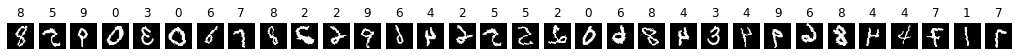

In [27]:
show_data(x.numpy().transpose(0,2,3,1),y.numpy())

**指定不同way數與shot數**

In [28]:
WAYS=5
SHOTS=3

sampler=FewShotSampler(target_dataset,target_dataset.classes[:WAYS],SHOTS,repeats=64)
target_dataloader=DataLoader(target_dataset, 
                    batch_size=BS_TRAIN, 
                    shuffle=False, # 注意，用自訂sampler必須關掉shuffle
                    num_workers=2,
                    pin_memory=True,
                    sampler=sampler)
for x,y in target_dataloader:
    print(x.shape,y.shape)
    print(y)
    break

torch.Size([32, 3, 28, 28]) torch.Size([32])
tensor([3, 4, 0, 4, 4, 2, 1, 1, 0, 3, 2, 4, 1, 2, 4, 1, 3, 4, 4, 1, 3, 0, 2, 3,
        0, 0, 4, 4, 1, 3, 2, 1])


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


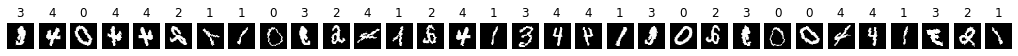

In [29]:
show_data(x.numpy().transpose(0,2,3,1),y.numpy())

* 用以上data loader with sample就可以拿來做few shot training
* 然後再使用test dataset驗證few shot training的效果

### Exercise 1

請調整Transfer Learning使用的 Data Loader，使得loader只會load出數字3,4,5，並且每個數字只會load出4個，並且不要shuffle

In [105]:
# ----修改這邊----
sampler=FewShotSampler(target_dataset,?????,repeats=1)
# ----------------

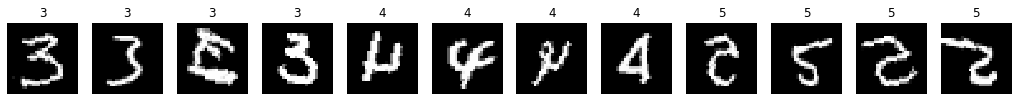

In [106]:
# 下面畫出來測試
target_dataloader=DataLoader(target_dataset, 
                    batch_size=BS_TRAIN, 
                    shuffle=False,
                    sampler=sampler)
for x,y in target_dataloader:
    break
show_data(x.numpy().transpose(0,2,3,1),y.numpy())

## 2. Loader for Meta Learning

Meta Learning的loader跟transfer learning不一樣


### 2.1 Source dataset
* 在train source dataset會將source dataset抽取成好幾組few shot tesks。
* 每組tesk會有N-way-K-shot的support dataset來支援模型推論，並且會推論query的資料為support中的哪一個類別。

在此我們用Iterable dataset來做

以下有些名詞易混淆先說明:

* sample, sample id: 在全部資料中的樣本以及對應id
* class sample, id in class: 在其中一個class中的資料樣本以及在該class中的對應id
* task id: 在meta learning會抽好幾個task (每個task涉及的class都不同)，task id為抽出序號。

#### 2.1.1 Meta Learning Source Dataset Object

In [163]:
source_dataset.classes

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [166]:
class MetaLearningDataset(tud.IterableDataset):
    def __init__(self,ds_object,classes,ways,shots,repeats=20):
        super().__init__()
        self.ds_object=ds_object
        self.classes=classes
        self.maps={v:i for i,v in enumerate(self.classes)} # 原本class順序與新順序對照表
        self.n_classes=len(classes)
        
        self.ways=ways
        self.shots=shots
        self.repeats=repeats
        
        self.class_sample_list=self.get_class_samples() #此處每個class分開做，之後要依照class抽取較方便
        self.class_sample_len=[*map(len,self.class_sample_list)]
        
    def get_class_samples(self):
        # 將class分開儲存
        indices_c=[[] for _ in range(self.n_classes)]
        
        # 屬於每個class的index儲存在對應class的list中
        for ii,yy in enumerate(self.ds_object.targets):
            yy=self.ds_object.classes[yy]
            if yy in self.classes:
                indices_c[self.maps[yy]].append(ii)
        return indices_c
    
    def get_x_in_ds(self,idx):
        return self.ds_object[idx][0]
    def get_y_in_ds(self,idx):
        return self.ds_object[idx][1]
    
    def __iter__(self):
        # 跟few shot sampler那邊一樣，需要好多資料才能組成batch，所以可重複抽數次
        for _ in range(self.repeats):
            #先決定好task抽取順序
            order=np.random.permutation(self.n_classes)
            #再決定好每個task中query對應的label，數字在0~WAYS-1 之間
            y_queries=[np.random.choice(range(self.ways), size=1, replace=False)[0] 
                  for _ in range(self.n_classes//self.ways)]
            
            # 接著輪迴抽task，共抽TOTAL_CLASSES/WAYS次，去掉小數點
            for task_id,y_query in enumerate(y_queries):
                # 每次有數個被抽到的class，取出對應的sample list
                picked=[self.class_sample_list[tt] for tt in order[self.ways*task_id:self.ways*(task_id+1)]]
                
                tmp=[] #用一個空list裝x 的sample的x
                # 對於每個piked
                for ii,id_in_class in enumerate(picked):
                    if ii==y_query:
                        # 若該class的序號剛好是是y_query，則除了SHOT個support data外還要多抽一個query data
                        sample_id=np.random.choice(id_in_class,size=self.shots+1, replace=False)
                    else:
                        # 如果該序號不是y_query，則抽SHOT個
                        sample_id=np.random.choice(id_in_class,size=self.shots, replace=False)
                    # 每個class抽到的東西先用stack 疊起來，會多一個axis在前面，每個class 維度為[SHOT(+1),CH,W,H]
                    tmp.append(torch.stack([*map(self.get_x_in_ds,sample_id)],dim=0))
                    # 有特殊model可能會利用到y，但大多數metric learning用不到
                    
                # Support那邊就把所有的class資料除了query那個以外全部cascade起來，不會多一個axis，維度為[WAY*SHOT,CH,W,H]
                x_support=torch.cat([tmp[ii][:self.shots] for ii in range(self.ways)],dim=0)
                
                # Query沿著y_query去抓他最後一個抽取出來的data
                x_query = tmp[y_query][-1:]
                
                # 最後concatenate起來，x維度為[WAY*SHOT+1,CH,W,H]，y只有一個一開始抽好的值
                yield torch.cat([x_support, x_query], dim=0),torch.tensor(y_query)

In [167]:
WAYS=3
SHOTS=10
source_meta_dataset=MetaLearningDataset(source_dataset,source_dataset.classes,WAYS,SHOTS,100)

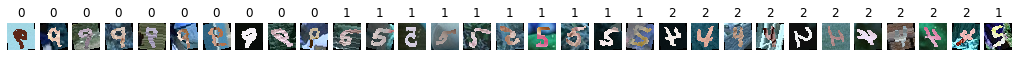

In [173]:
for x,y in source_meta_dataset:
    break
# 在取batch前，每個task就有一堆資料了
# 注意query在最後一個，他的y會跟前面同類的support一樣
show_data(x.numpy().transpose(0,2,3,1),list(np.repeat(range(WAYS),SHOTS))+[y.numpy()])

#### 2.1.2 Meta Learning Source Data Loader

In [33]:
source_dataloader=DataLoader(source_meta_dataset, # 指定source dataset物件
                    batch_size=BS_TRAIN,     # batch size
                    shuffle=False,            # 如果是iterable dataset, shuffle要關掉
                    num_workers=2,           # 開啟兩個thread
                    pin_memory=True)         # 其他增加讀取速度的功能都可以開

In [34]:
for x,y in source_dataloader:
    print(x.shape,y.shape) # X維度為[BS,WAY*SHOT+1,CH,W,H]，Y維度為[BS]
    print(y) #Y範圍會在0~WAY-1之間
    break

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


torch.Size([32, 31, 3, 28, 28]) torch.Size([32])
tensor([2, 1, 1, 0, 0, 1, 1, 0, 2, 2, 2, 2, 2, 1, 2, 0, 2, 1, 2, 1, 1, 0, 0, 1,
        1, 2, 2, 2, 2, 1, 0, 1])


### Exercise 2
限制source dataset只用數字3,4,5,6,7,8來訓練3-way-8-shot，請試著製作相關data loader中的 dataset object

In [174]:
# ----修改這邊----
WAYS=?
SHOTS=?
source_meta_dataset=MetaLearningDataset(source_dataset,???,repeats=1)
# ----------------

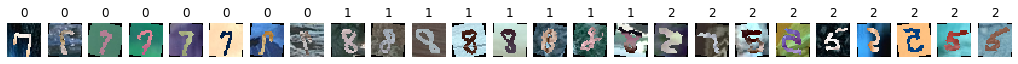

In [181]:
for x,y in source_meta_dataset:
    break
show_data(x.numpy().transpose(0,2,3,1),list(np.repeat(range(WAYS),SHOTS))+[y.numpy()])

### 2.2 Target dataset
* 對於Metric based Meta Learning來講，Target中的data不是拿來train而是直接作為input的一環
* 但也可以試試看adaptation training

#### 2.2.1 Meta dataset using target data

* 所以第一個我們試著直接用target dataset組成Meta dataset
* 就跟Source那邊一樣

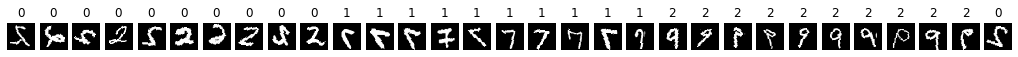

In [35]:
target_meta_dataset=MetaLearningDataset(target_dataset,target_dataset.classes,WAYS,SHOTS,50)
for x,y in target_meta_dataset:
    break
# 在取batch前，每個task就有一堆資料了
# 注意query在最後一個，他的y會跟前面同類的support一樣
show_data(x.numpy().transpose(0,2,3,1),list(np.repeat(range(WAYS),SHOTS))+[y.numpy()])

* 做成data loader 也一樣，就這樣拿去test就好，不做任何更新
* 就相信target的各種類資料間有穩定的相互關係

In [36]:
target_dataloader=DataLoader(target_meta_dataset, # 指定source dataset物件
                    batch_size=BS_TRAIN,     # batch size
                    shuffle=False,            # 如果是iterable dataset, shuffle要關掉
                    num_workers=2,           # 開啟兩個thread
                    pin_memory=True)         # 其他增加讀取速度的功能都可以開
for x,y in target_dataloader:
    print(x.shape,y.shape) # X維度為[BS,WAY*SHOT+1,CH,W,H]，Y維度為[BS]
    print(y) #Y範圍會在0~WAY-1之間
    break

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


torch.Size([32, 31, 3, 28, 28]) torch.Size([32])
tensor([0, 2, 0, 2, 0, 0, 0, 2, 1, 2, 2, 1, 0, 1, 2, 2, 0, 2, 2, 0, 2, 2, 2, 1,
        2, 1, 2, 0, 1, 0, 2, 1])


#### 2.2.2 Adaptation with target support dataset

In [88]:
# 使用剛剛transfer learning的sampler 對target data進行sample 模擬N-way-k的情況
sampler=FewShotSampler(target_dataset,
                       classes=target_dataset.classes[:WAYS],
                       shots=SHOTS,repeats=1,shuffle=False) #注意這邊若是Metric Learning Shuffle要關掉

In [94]:
# 然後把每個用stack疊起來多一個rank，大小變成[WAYS*SHOTS,CH,W,H]
tgt_support_x=torch.stack([target_dataset[idx][0] for idx in sampler])
# 把y也拿起來做對照 (這邊只是對照而已後面用不到)
tgt_support_y=np.array([target_dataset[idx][1] for idx in sampler])

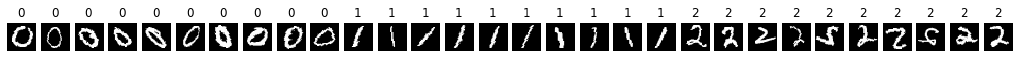

In [95]:
# 這n-way-k-shot的資料集可以直接餵給model，做target task的適應
show_data(tgt_support_x.detach().numpy().transpose(0,2,3,1),tgt_support_y)

In [86]:
# 這之後就可以用test dataset來測試前面target task適應的效果 (這樣就只針對一個task去做測試，前面meta testing是一次測好幾個task)
BS_TEST=128
test_dataloader = tud.DataLoader(test_dataset,
                             batch_size=BS_TEST,
                             shuffle=True,
                             num_workers=2,
                             pin_memory=True)
for x,y in test_dataloader:
    print(x.shape,y.shape) # X維度為[BS_TEST,CH,W,H]，Y維度為[BS_TEST]
    print(y) #Y範圍會在0~WAY-1之間
    break

torch.Size([128, 3, 28, 28]) torch.Size([128])
tensor([1, 0, 2, 2, 5, 9, 9, 6, 5, 7, 2, 2, 8, 8, 4, 9, 2, 2, 8, 2, 0, 3, 9, 3,
        3, 7, 6, 9, 4, 3, 2, 8, 1, 7, 8, 8, 6, 6, 2, 3, 7, 1, 2, 4, 4, 4, 8, 1,
        0, 9, 6, 5, 0, 8, 9, 4, 7, 4, 1, 2, 0, 8, 2, 7, 1, 9, 5, 6, 0, 2, 2, 1,
        3, 5, 0, 1, 7, 0, 5, 8, 4, 4, 2, 3, 0, 6, 7, 8, 0, 2, 2, 6, 4, 5, 6, 2,
        2, 3, 5, 7, 4, 3, 1, 9, 9, 7, 6, 8, 1, 7, 1, 7, 7, 5, 9, 1, 0, 0, 5, 8,
        9, 9, 0, 6, 3, 8, 6, 0])


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


#### 2.2.2 Adaptation using target dataset

* 因為target資料集也有些資料，所以我們可拿那些資料集(只有n*k張)來做adaptation (fine-tune training)
* 但根據文獻，效果有限

In [98]:
# 對於target support dataset,形成loader
sampler.shuffle=True # 把剛剛的sampler開啟shuffle，可以shuffle來形成不同訓練順序

target_dataloader2=tud.DataLoader(target_dataset, 
                    batch_size=BS_TRAIN,
                    shuffle=False,sampler=sampler)
for x,y in target_dataloader2:
    print(x.shape,y.shape)
    print(y)
    break

torch.Size([30, 3, 28, 28]) torch.Size([30])
tensor([2, 2, 2, 1, 1, 2, 0, 0, 0, 1, 1, 1, 0, 2, 2, 0, 1, 2, 0, 2, 0, 2, 1, 0,
        1, 1, 0, 1, 0, 2])


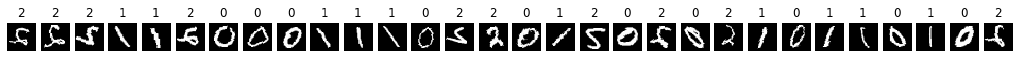

In [99]:
# 以下是sample出來的訓練集，其實這邊就是拿剛剛support同樣資料集來做query，做一些fine-tune
show_data(x.numpy().transpose(0,2,3,1),y.numpy())

可以在最後fine-tune使用test_dataloader來看使用這組query資料來做fine-tune效果會不會變好